In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
dfenduse = pd.read_excel("./data/HS2012-17-BEC5 -- 08 Nov 2018.xlsx", sheet_name="HS17BEC5", usecols = ["HS6", "BEC5EndUse"], dtype=str)

dfenduse["BEC5EndUse"].unique()

# Define a dictionary for replacements
replacement_dict = {
    "INT/CONS": "INT",
    'CONS/INT': "CONS",
    'CAP/INT': "CAP",
    "INT/CAP": "INT",
    'CAP/CONS': "CAP",
    'CONS/CAP': "CONS",
    np.nan: "OTHER",
}

dfenduse["BEC5EndUse"] = dfenduse["BEC5EndUse"].replace(replacement_dict)

dfenduse["BEC5EndUse"].unique()

array(['CAP', 'INT', 'CONS', 'OTHER'], dtype=object)

In [3]:
country_list = pd.read_csv('./data/top_50_non_eu.csv', dtype={'CTY_CODE': str})

country_list.loc[len(country_list)] = ["EUROPEAN UNION", 0 , "0003"]

In [4]:
country_list.head()

,CTY_NAME,total_imports,CTY_CODE
0,CHINA,5.728638e+12,5700
1,MEXICO,4.385957e+12,2010
2,CANADA,4.161438e+12,1220
3,JAPAN,1.701399e+12,5880
4,"KOREA, SOUTH",1.045098e+12,5800


In [ ]:
def download_imports(cntry_code, year):

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    hs = 'HS6'

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    end_use = "hs?get=CTY_NAME,CON_VAL_YR,CAL_DUT_YR,I_COMMODITY,I_COMMODITY_SDESC"

    surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

    surl  = surl + my_key + "&time=" + year + "-12" + "&COMM_LVL=" + hs 

    url = surl + "&CTY_CODE=" + cntry_code

    r = requests.get(url) 
        
    print(cntry_code, r)
        
    df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
        # Note that the first entry is the labels

    df.columns = r.json()[0]

        #######################################################################

    df.time = pd.to_datetime(df.time, format="%Y-%m")

    df["imports"] = df["CON_VAL_YR"].astype(float)

    df["duty"] = df["CAL_DUT_YR"].astype(float)

    df["tariff"] = df["duty"] / df["imports"]

    df[hs] = df["I_COMMODITY"].astype(str)

    return df


In [20]:
def download_imports_month(cntry_code, year, month):

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    hs = 'HS6'

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    end_use = "hs?get=CTY_NAME,CON_VAL_MO,CAL_DUT_MO,I_COMMODITY,I_COMMODITY_SDESC"

    surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

    surl  = surl + my_key + "&time=" + year + "-" + month + "&COMM_LVL=" + hs

    url = surl + "&CTY_CODE=" + cntry_code

    r = requests.get(url) 
        
    print(cntry_code, r)
        
    df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
        # Note that the first entry is the labels

    df.columns = r.json()[0]

        #######################################################################

    df.time = pd.to_datetime(df.time, format="%Y-%m")

    df["imports"] = df["CON_VAL_MO"].astype(float)

    df["duty"] = df["CAL_DUT_MO"].astype(float)

    df["tariff"] = df["duty"] / df["imports"]

    df[hs] = df["I_COMMODITY"].astype(str)

    return df

In [21]:
def get_good_composition(country_code, country_name, year, dfenduse=dfenduse, month=None):

    if month is None:
        # Use yearly data
        df = download_imports(country_code, year)
    else:
        # Use monthly data
        df = download_imports_month(country_code, year, month)

    merged_df = pd.merge(
        dfenduse, 
        df, 
        on="HS6", 
        how="outer",  # Use 'outer' to include all rows and identify mismatches
        indicator=True  # Adds a column '_merge' to indicate the source of each row
        )
    
    grp = merged_df.groupby(["BEC5EndUse"])

    share_df = grp.agg({"imports": "sum", "duty": "sum"})

    share_df.reset_index(inplace=True)

    name_mapping = {
    "CAP": "Capital Goods",
    "CONS": "Consumption Goods",
    "INT": "Intermediate Inputs",
    "OTHER": "Other",
    }   

    # Replace names in the column using the dictionary
    share_df["BEC5EndUse"] = share_df["BEC5EndUse"].replace(name_mapping)

    share_df.rename(columns = {"BEC5EndUse": "Good Type"}, inplace = True)

    share_df["share of imports"] = 100*share_df["imports"] / share_df["imports"].sum()

    share_df["tariff"] = 100*share_df["duty"] / share_df["imports"]

    share_df["CTY_NAME"] = country_name

    share_df.set_index(["CTY_NAME", "Good Type"], inplace=True)

    return share_df

In [22]:
out = get_good_composition("-", "ALL COUNTRIES", "2024")

- <Response [200]>


In [23]:
out.head()

imports          duty  \
CTY_NAME      Good Type                                         
ALL COUNTRIES Capital Goods        6.227215e+11  9.372464e+09   
              Consumption Goods    8.869232e+11  3.365306e+10   
              Intermediate Inputs  1.400733e+12  2.944168e+10   
              Other                2.496546e+09  1.321933e+06   

                                   share of imports    tariff  
CTY_NAME      Good Type                                        
ALL COUNTRIES Capital Goods               21.378246  1.505081  
              Consumption Goods           30.448384  3.794360  
              Intermediate Inputs         48.087662  2.101876  
              Other                        0.085707  0.052950

In [24]:
out = get_good_composition("-", "ALL COUNTRIES", "2025", month = "07")

- <Response [200]>


In [25]:
out.head()

imports          duty  \
CTY_NAME      Good Type                                         
ALL COUNTRIES Capital Goods        6.539903e+10  4.193695e+09   
              Consumption Goods    6.908086e+10  1.117311e+10   
              Intermediate Inputs  1.249913e+11  1.131175e+10   
              Other                1.301797e+08  5.804400e+05   

                                   share of imports     tariff  
CTY_NAME      Good Type                                         
ALL COUNTRIES Capital Goods               25.192095   6.412473  
              Consumption Goods           26.610356  16.173959  
              Intermediate Inputs         48.147402   9.050025  
              Other                        0.050146   0.445876

In [49]:
out2024 = get_good_composition("-", "ALL COUNTRIES", "2024")
out2024.reset_index(inplace=True)

out2025 = get_good_composition("-", "ALL COUNTRIES", "2025", month="07")
out2025.reset_index(inplace=True)


- <Response [200]>
- <Response [200]>


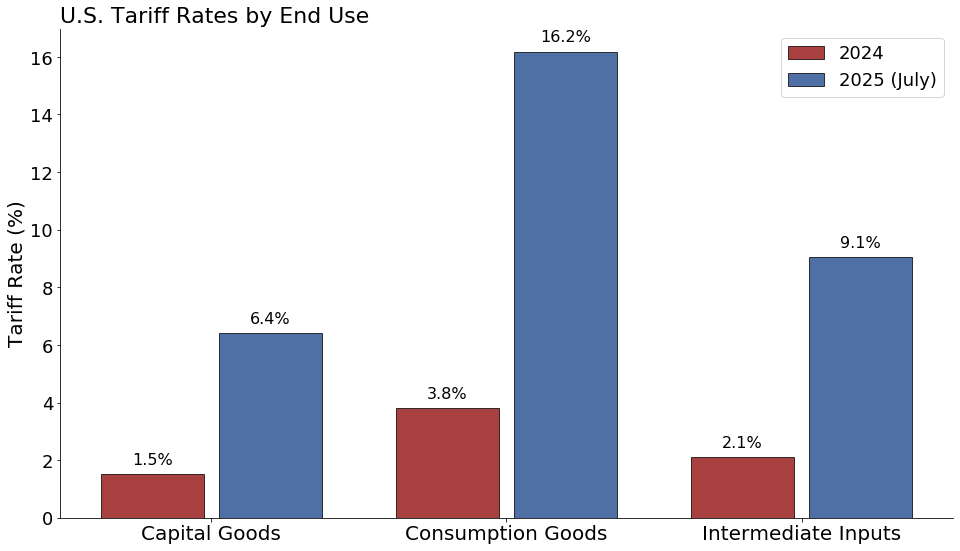

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))

alpha = 0.60
width = 0.40

# Set up bar positioning
x_labels = out2024.iloc[:-1]["Good Type"]
bar_width = 0.35
gap = 0.05
x_pos = np.arange(len(x_labels))

# First set of bars (2024)
bars1 = ax.bar(
    x_pos - bar_width/2 - gap/2,
    out2024.iloc[:-1].tariff,
    bar_width,
    label='2024',
    color='darkred',
    alpha=0.75,
    edgecolor="black"
)

# Second set of bars (2025)
bars2 = ax.bar(
    x_pos + bar_width/2 + gap/2,
    out2025.iloc[:-1].tariff,
    bar_width,
    label='2025 (July)',
    color=tuple(np.array([20, 64, 134]) / 255),
    alpha=0.75,
    edgecolor="black"
)

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)

# Annotate first set of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.25,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=16
    )

# Annotate second set of bars
for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.25,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=16
    )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=18)

ax.set_title("U.S. Tariff Rates by End Use", fontsize=22, loc="left")
ax.set_ylabel('Tariff Rate (%)', fontsize=20)
ax.legend(fontsize=18)

plt.show()
